# Intro
This notebook is to attempt training on token embeddings themselves. The idea is that we've encoded positional information sufficiently that we can now learn on the concatenated embeddings themselves.

In [154]:
%load_ext autoreload
%autoreload 2

import torch
from embed_patches import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
USE_GPU = True

print("GPU detected?", torch.cuda.is_available())
if USE_GPU and torch.cuda.is_available():
	device = torch.device('cuda')
	print("\nNote: gpu available & selected!")
else:
	device = torch.device('cpu')
	print("\nNote: gpu NOT available!")

GPU detected? False

Note: gpu NOT available!


Get train directory stats

In [156]:
patch_dir = "/home/data/tinycam/train/train.hdf5"
label_dict_path = "/home/codex_analysis/codex-analysis/code/outputs/train-cam-cam16-224-background-labeldict.obj"
image_names = print_X_names(label_dict_path)
dim_dict = gather_Z_dims(patch_dir, image_names)

Gathering dimensions...
done!


In [157]:
i_max = 0
j_max = 0
for v in dim_dict.values():
    if v[0] > i_max:
        i_max = v[0]
    if v[1] > j_max:
        j_max = v[1]

print("max sizes are:", i_max, j_max)


max sizes are: 102 108


*Note these values above:* we want to pad our images to all be the same size for any downstream learning

In [158]:
from models import ResNet18 
model = ResNet18(n_classes=2, in_channels=3, z_dim=128, supervised=False, no_relu=False, loss_type='triplet', tile_size=224, activation='relu')

In [159]:
scope = "all" 

chkpt = "/home/codex_analysis/codex-analysis/models/cam/ResNet18-hdf5_triplets_random_loading-224-label_selfsup-custom_loss-on_cam-cam16-filtration_background.sd"
checkpoint = torch.load(chkpt, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
prev_epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Running inference
We want to process all patches in the training set and then attempt to learn from the concatenated embeddings

Note: This should take roughly 20min with GPU

In [160]:
patch_dir = "/home/data/tinycam/train/train.hdf5"
save_dir = "/home/data/tinycam/train/Zs"
# run below if needed/fresh directory:
#--------------------------------------
# construct_Zs_efficient(model, patch_dir, dim_dict, save_dir, device, scope=scope)

Pseudo test set. get stats first.

In [161]:
patch_dir = "/home/data/tinycam/val/val.hdf5"
label_dict_path = "/home/codex_analysis/codex-analysis/code/outputs/val-cam-cam16-224-background-labeldict.obj"
image_names = print_X_names(label_dict_path, arm="val")
dim_dict = gather_Z_dims(patch_dir, image_names, arm="val")

Gathering dimensions...
done!


In [162]:
i_max = 0
j_max = 0
for v in dim_dict.values():
    if v[0] > i_max:
        i_max = v[0]
    if v[1] > j_max:
        j_max = v[1]

print("max sizes are:", i_max, j_max)

max sizes are: 97 72


In [163]:
save_dir = "/home/data/tinycam/val/Zs"
# run below if needed/fresh directory:
#--------------------------------------
# construct_Zs_efficient(model, patch_dir, dim_dict, save_dir, device, scope=scope, arm="val")

# Full analysis

In [172]:
from embed_patches import run_all_lofi

embed_dict_path = "/home/codex_analysis/codex-analysis/code/train_sampled_inference_z_embeds.obj"
Zs_path_train = "/home/data/tinycam/train/Zs"
Zs_path_val = "/home/data/tinycam/val/Zs"
label_dict_path_train = "/home/codex_analysis/codex-analysis/code/outputs/train-cam-cam16-224-background-labeldict.obj"
label_dict_path_val = "/home/codex_analysis/codex-analysis/code/outputs/val-cam-cam16-224-background-labeldict.obj"

model_strs, y_probs_all, ys_all, FIs, kmeans_models = run_all_lofi(device, embed_dict_path, Zs_path_train, label_dict_path_train, Zs_path_val, label_dict_path_val)

Beginning shallow training on suite of 27 models
Training [ K5-kmeans_euc-N0-L0 ] --> model # 1 / 27
	overall mean accuracy 0.7333333333333333
Training [ K5-kmeans_euc-N0-L1 ] --> model # 2 / 27
	overall mean accuracy 0.7333333333333333
Training [ K5-kmeans_euc-N0-L0.5 ] --> model # 3 / 27


The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.7333333333333333
Training [ K5-kmeans_euc-N1-L0 ] --> model # 4 / 27
	overall mean accuracy 0.7333333333333333
Training [ K5-kmeans_euc-N1-L1 ] --> model # 5 / 27
	overall mean accuracy 0.7333333333333333
Training [ K5-kmeans_euc-N1-L0.5 ] --> model # 6 / 27


The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.7333333333333333
Training [ K5-kmeans_euc-N2-L0 ] --> model # 7 / 27
	overall mean accuracy 0.7111111111111111
Training [ K5-kmeans_euc-N2-L1 ] --> model # 8 / 27


The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.6888888888888889
Training [ K5-kmeans_euc-N2-L0.5 ] --> model # 9 / 27


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.6888888888888889
Training [ K10-kmeans_euc-N0-L0 ] --> model # 10 / 27
	overall mean accuracy 0.7333333333333333
Training [ K10-kmeans_euc-N0-L1 ] --> model # 11 / 27
	overall mean accuracy 0.7333333333333333
Training [ K10-kmeans_euc-N0-L0.5 ] --> model # 12 / 27
	overall mean accuracy 0.7333333333333333
Training [ K10-kmeans_euc-N1-L0 ] --> model # 13 / 27
	overall mean accuracy 0.7111111111111111
Training [ K10-kmeans_euc-N1-L1 ] --> model # 14 / 27
	overall mean accuracy 0.7555555555555555
Training [ K10-kmeans_euc-N1-L0.5 ] --> model # 15 / 27


The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.7555555555555555
Training [ K10-kmeans_euc-N2-L0 ] --> model # 16 / 27


The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.6888888888888889
Training [ K10-kmeans_euc-N2-L1 ] --> model # 17 / 27


The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.7111111111111111
Training [ K10-kmeans_euc-N2-L0.5 ] --> model # 18 / 27


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.7111111111111111
Training [ K15-kmeans_euc-N0-L0 ] --> model # 19 / 27
	overall mean accuracy 0.7333333333333333
Training [ K15-kmeans_euc-N0-L1 ] --> model # 20 / 27
	overall mean accuracy 0.7333333333333333
Training [ K15-kmeans_euc-N0-L0.5 ] --> model # 21 / 27
	overall mean accuracy 0.7333333333333333
Training [ K15-kmeans_euc-N1-L0 ] --> model # 22 / 27
	overall mean accuracy 0.7111111111111111
Training [ K15-kmeans_euc-N1-L1 ] --> model # 23 / 27


The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.6666666666666666
Training [ K15-kmeans_euc-N1-L0.5 ] --> model # 24 / 27


The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.6888888888888889
Training [ K15-kmeans_euc-N2-L0 ] --> model # 25 / 27


The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.6888888888888889
Training [ K15-kmeans_euc-N2-L1 ] --> model # 26 / 27


The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.7555555555555555
Training [ K15-kmeans_euc-N2-L0.5 ] --> model # 27 / 27


The max_iter was reached which means the coef_ did not converge


	overall mean accuracy 0.7333333333333333


The max_iter was reached which means the coef_ did not converge


In [1]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pandas as pd

aucs = []
for idx, y_prob in enumerate(y_probs_all):
    preds = y_prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(ys_all[idx], preds)
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, linewidth=1, label=model_strs[idx] + ' (AUC = %0.2f)' % roc_auc)

plt.title('ROC Curve')
# plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

d = {'model': model_strs, 'aucs': aucs}
df = pd.DataFrame(data=d).sort_values(by="aucs", ascending=False)
df

NameError: name 'y_probs_all' is not defined

In [185]:
from utils import serialize
serialize(df, "aucs_df.obj")

----------------------------

# Cluster the randomly sampled embeddings
This will help us:
- Create cluster labels for tokens: easy visualization of the source data
- observe the continuous space created by AUL 

total embeds: 4440
collapsing from dim 128 --> 2


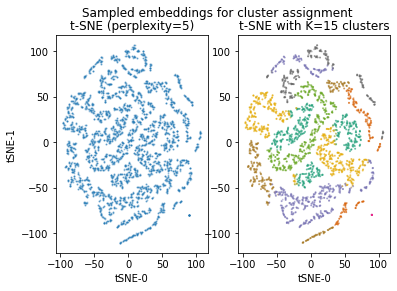

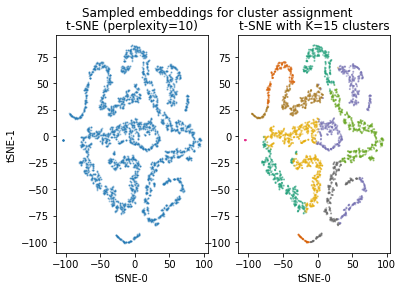

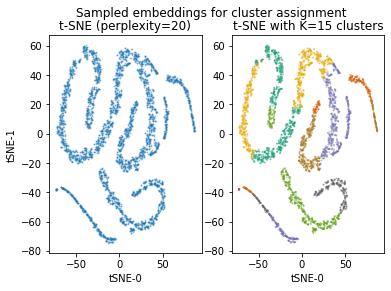

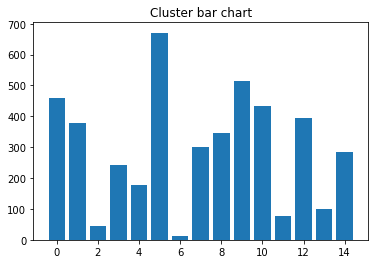

In [152]:
K=15
embed_dict_path = "/home/codex_analysis/codex-analysis/code/train_sampled_inference_z_embeds.obj"
kmeans_model = fit_clustering(embed_dict_path, K=K)

# Visualize a single image
With cluster labels, we can get a better view of the model embeddings. Let's take a look at "normal_045"

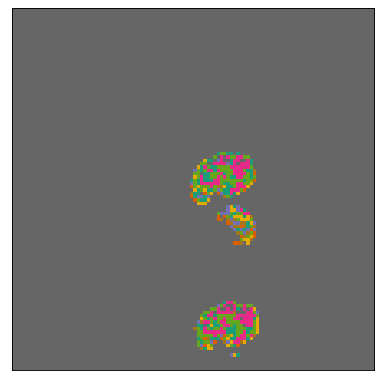

In [12]:
Z_path = "/home/data/tinycam/train/Zs/Z-tumor_045.npy"
visualize_Z(Z_path, kmeans_model)

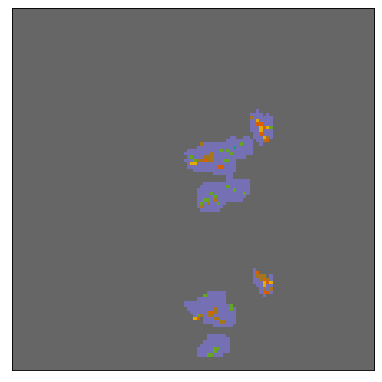

In [13]:
Z_path = "/home/data/tinycam/train/Zs/Z-normal_045.npy"
visualize_Z(Z_path, kmeans_model)

# Train on Zs
We have a few models we can train based on these Z data.

Those with in-situ explanation maps:
- ConvMixer/AttnMixer/S4Mixer/ViT-tiny on Z
- ConvMixer/AttnMixer/S4Mixer/ViT-tiny on Z's cluster labels

Baseline classifiers without explanation maps:
- ElasticNet/XGBoost on meanpool Z
- ElasticNet/XGBoost on maxpool Z
- ElasticNet/XGBoost on cat(meanpool, maxpool) Z
- ElasticNet/XGBoost on normalized bag of clusters

In [14]:
Zs_path = "/home/data/tinycam/train/Zs"
n_normal, n_tumor = 0,0
for Z_file in os.listdir(Zs_path):
    no_ext = Z_file.split(".npy")[0]
    id_name = no_ext.split("-")[1]
    Z_class = id_name.split("_")[0]
    if Z_class == "normal":
        n_normal += 1
    else:
        n_tumor += 1

print("0 / 1 class cases:", n_normal, n_tumor)

0 / 1 class cases: 111 111


We want to create a mini-validation set to make sure we don't overfit models. Say, 10% of training, or 22 samples.

In [15]:
# Zs_path = "/home/data/tinycam/train/Zs"
# n_normal, n_tumor = 0,0
# train_set = []
# val_set = []
# desired_per_class = 0

# for Z_file in os.listdir(Zs_path):
#     no_ext = Z_file.split(".npy")[0]
#     id_name = no_ext.split("-")[1]
#     Z_class = id_name.split("_")[0]
#     if Z_class == "normal":
#         if n_normal >= desired_per_class:
#             train_set.append(Z_file)
#         else:
#             val_set.append(Z_file)
#             n_normal += 1
#     else: # tumor
#         if n_tumor >= desired_per_class:
#             train_set.append(Z_file)
#         else:
#             val_set.append(Z_file)
#             n_tumor += 1

# print("train / val split:", len(train_set), len(val_set))

Begin training!

In [110]:
from sklearn.ensemble import GradientBoostingClassifier
Zs_path_train = "/home/data/tinycam/train/Zs"
Zs_path_val = "/home/data/tinycam/val/Zs"

## Gradient Boosting

In [111]:
label_dict_path_train = "/home/codex_analysis/codex-analysis/code/outputs/train-cam-cam16-224-background-labeldict.obj"
label_dict_path_val = "/home/codex_analysis/codex-analysis/code/outputs/val-cam-cam16-224-background-labeldict.obj"

m="clusterbag"
adapter = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
adapter_cb, y_probs_cb, ys_cb = train_on_Z(adapter, device, None, Zs_path_train, Zs_path_val, label_dict_path_train, label_dict_path_val, None, None, epochs=20, mode=m, kmeans_model=kmeans_model)

Z train is shape: torch.Size([222, 15])
Z val is shape: torch.Size([45, 15])
overall mean accuracy 0.7333333333333333
Fitting sci-kit learn models: returning y_probs, ys


In [118]:
m="coclusterbag"
adapter = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
adapter_ccb, y_probs_ccb, ys_ccb = train_on_Z(adapter, device, None, Zs_path_train, Zs_path_val, label_dict_path_train, label_dict_path_val, None, None, epochs=20, mode=m, kmeans_model=kmeans_model)

Z train is shape: torch.Size([222, 135])
Z val is shape: torch.Size([45, 135])
overall mean accuracy 0.6888888888888889
Fitting sci-kit learn models: returning y_probs, ys


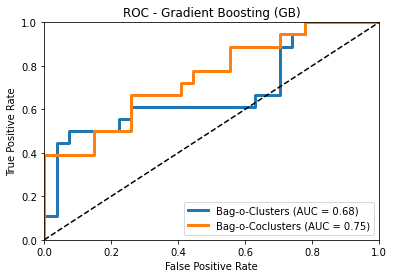

In [119]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

y_probs = [y_probs_cb, y_probs_ccb]
ys = [ys_cb, ys_ccb]
model_str = ["Bag-o-Clusters", "Bag-o-Coclusters"]

for idx, y_prob in enumerate(y_probs):
    preds = y_prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(ys[idx], preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=3, label=model_str[idx] + ' (AUC = %0.2f)' % roc_auc)

plt.title('ROC - Gradient Boosting (GB)')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



## Feature Importances - Gini

sum of importance: 1.0
Feature: 0, Score: 0.09875
Feature: 1, Score: 0.09025
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.09327
Feature: 4, Score: 0.01434
Feature: 5, Score: 0.21017
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.05354
Feature: 8, Score: 0.06812
Feature: 9, Score: 0.12554
Feature: 10, Score: 0.08178
Feature: 11, Score: 0.06112
Feature: 12, Score: 0.04268
Feature: 13, Score: 0.01775
Feature: 14, Score: 0.04266


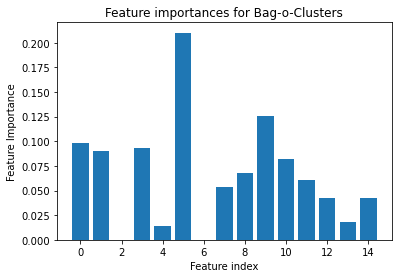

In [35]:
importance_cb = adapter_cb.feature_importances_
print("sum of importance:", np.sum(importance_cb))
for i,v in enumerate(importance_cb):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance_cb))], importance_cb)
plt.xlabel("Feature index")
plt.ylabel("Feature Importance")
plt.title("Feature importances for Bag-o-Clusters")
plt.show()

sum of importance: 0.9999999999999999
Feature: 0, Score: 0.05047
Feature: 1, Score: 0.06248
Feature: 2, Score: 0.00241
Feature: 3, Score: 0.05700
Feature: 4, Score: 0.00308
Feature: 5, Score: 0.20882
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.01309
Feature: 8, Score: 0.03200
Feature: 9, Score: 0.08674
Feature: 10, Score: 0.05589
Feature: 11, Score: 0.02523
Feature: 12, Score: 0.01820
Feature: 13, Score: 0.00721
Feature: 14, Score: 0.01598
Feature: 15, Score: 0.00011
Feature: 16, Score: 0.00428
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00465
Feature: 19, Score: 0.00128
Feature: 20, Score: 0.00035
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.01388
Feature: 23, Score: 0.01239
Feature: 24, Score: 0.01142
Feature: 25, Score: 0.01216
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00683
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00963
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.01227
Feature: 33, Score: 0.00001
Feature: 34, Score: 

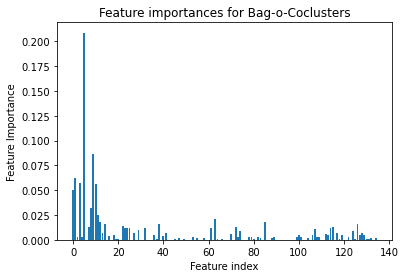

In [36]:
importance_ccb = adapter_ccb.feature_importances_
print("sum of importance:", np.sum(importance_ccb))
for i,v in enumerate(importance_ccb):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance_ccb))], importance_ccb)
plt.xlabel("Feature index")
plt.ylabel("Feature Importance")
plt.title("Feature importances for Bag-o-Coclusters")
plt.show()

## Feature Importance - Shapley

In [37]:
import shap
from dataloader import EmbedDataset

batch_size_train = len(os.listdir(Zs_path_train))
train_dataset = EmbedDataset(Zs_path_train, label_dict_path_train, split_list=None, mode="clusterbag", kmeans_model=kmeans_model, arm="train")
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=2)
for idx, (Z_train, y_train) in enumerate(train_loader):
    break

batch_size_val = len(os.listdir(Zs_path_val))
val_dataset = EmbedDataset(Zs_path_val, label_dict_path_val, split_list=None, mode="clusterbag", kmeans_model=kmeans_model, arm="val")
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True, num_workers=2)
for idx, (Z_val, y_val) in enumerate(val_loader):
    break

[0.45368025 0.24945889 0.         0.44259839 0.06434113 1.27596669
 0.         0.21211668 0.35195749 0.26148546 0.5048497  0.16347687
 0.10742121 0.02754494 0.10203253]


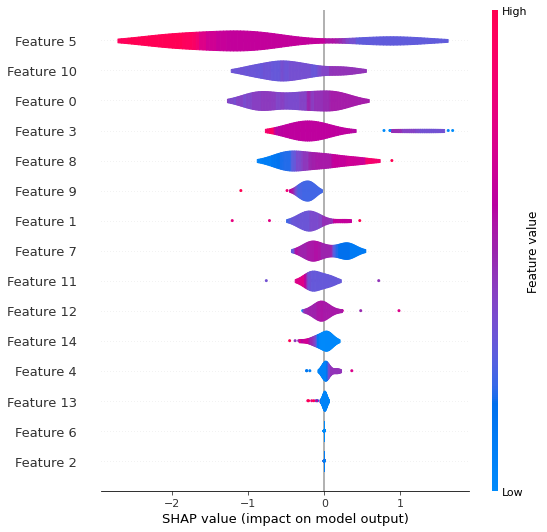

In [38]:
# explainer_cb = shap.Explainer(adapter_cb)
explainer_cb = shap.explainers.Tree(adapter_cb, data=Z_train.numpy())
shap_values_cb = explainer_cb(Z_val.numpy())
shap_importance_cb = shap_values_cb.abs.mean(0).values
print(shap_importance_cb)
shap.summary_plot(shap_values_cb, plot_type='violin', max_display=20)


In [39]:
# below code crashes
#-------------------
# # explainer_ccb = shap.Explainer(adapter_ccb)
# explainer_ccb = shap.explainers.Tree(adapter_ccb, data=Z_train.numpy())
# shap_values_ccb = explainer_ccb(Z_val.numpy())
# shap_importance_ccb = shap_values_ccb.abs.mean(0).values
# print(shap_importance_ccb)
# shap.summary_plot(shap_values_ccb, plot_type='violin', max_display=20)


It appears SHAP breaks down with many features?

## Switching to linear model for coeffs

In [120]:
from sklearn.linear_model import LogisticRegression

label_dict_path_train = "/home/codex_analysis/codex-analysis/code/outputs/train-cam-cam16-224-background-labeldict.obj"
label_dict_path_val = "/home/codex_analysis/codex-analysis/code/outputs/val-cam-cam16-224-background-labeldict.obj"

m="clusterbag"
adapter = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0, random_state=0)
adapter_cben, y_probs_cben, ys_cben = train_on_Z(adapter, device, None, Zs_path_train, Zs_path_val, label_dict_path_train, label_dict_path_val, None, None, epochs=20, mode=m, kmeans_model=kmeans_model)

Z train is shape: torch.Size([222, 15])
Z val is shape: torch.Size([45, 15])
overall mean accuracy 0.7333333333333333
Fitting sci-kit learn models: returning y_probs, ys


In [124]:
m="coclusterbag"
adapter = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0, random_state=0)
adapter_ccben, y_probs_ccben, ys_ccben = train_on_Z(adapter, device, None, Zs_path_train, Zs_path_val, label_dict_path_train, label_dict_path_val, None, None, epochs=20, mode=m, kmeans_model=kmeans_model)

Z train is shape: torch.Size([222, 135])
Z val is shape: torch.Size([45, 135])
overall mean accuracy 0.6888888888888889
Fitting sci-kit learn models: returning y_probs, ys


The max_iter was reached which means the coef_ did not converge


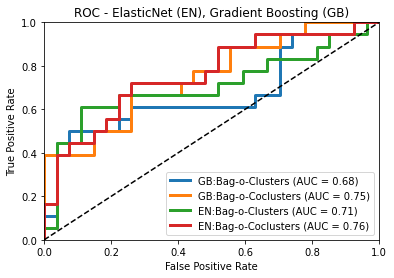

In [125]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

y_probs = [y_probs_cb, y_probs_ccb, y_probs_cben, y_probs_ccben]
ys = [ys_cb, ys_ccb, ys_cben, ys_ccben]
model_str = ["GB:Bag-o-Clusters", "GB:Bag-o-Coclusters", "EN:Bag-o-Clusters", "EN:Bag-o-Coclusters"]

for idx, y_prob in enumerate(y_probs):
    preds = y_prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(ys[idx], preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=3, label=model_str[idx] + ' (AUC = %0.2f)' % roc_auc)

plt.title('ROC - ElasticNet (EN), Gradient Boosting (GB)')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

sum of importance: -1.1602033201811586
Feature: 0, Score: 0.29157
Feature: 1, Score: 0.44212
Feature: 2, Score: -0.01511
Feature: 3, Score: -0.14139
Feature: 4, Score: 0.06075
Feature: 5, Score: -1.21488
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.07855
Feature: 8, Score: 0.43108
Feature: 9, Score: 0.04998
Feature: 10, Score: 0.29912
Feature: 11, Score: 0.04121
Feature: 12, Score: -0.18250
Feature: 13, Score: 0.05787
Feature: 14, Score: -0.01693
Feature: 15, Score: 0.02842
Feature: 16, Score: -0.63894
Feature: 17, Score: 0.13872
Feature: 18, Score: -0.37470
Feature: 19, Score: 0.46471
Feature: 20, Score: -0.27623
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.68740
Feature: 23, Score: 0.29985
Feature: 24, Score: 0.05773
Feature: 25, Score: -0.19785
Feature: 26, Score: 0.46907
Feature: 27, Score: 0.79579
Feature: 28, Score: -0.07428
Feature: 29, Score: -0.22024
Feature: 30, Score: 0.22545
Feature: 31, Score: 0.07928
Feature: 32, Score: -0.35994
Feature: 33, Score: -0.65885
Featur

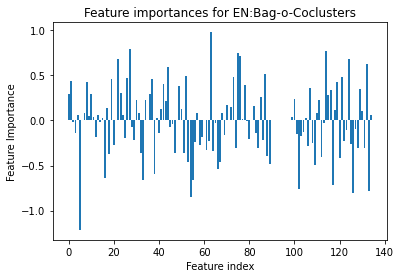

In [62]:
importance_ccben = adapter_ccben.coef_[0]
print("sum of importance:", np.sum(importance_ccben))
for i,v in enumerate(importance_ccben):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance_ccben))], importance_ccben)
plt.xlabel("Feature index")
plt.ylabel("Feature Importance")
plt.title("Feature importances for EN:Bag-o-Coclusters")
plt.show()

# Build LoFI Maps

In [141]:
from embed_patches import lofi_map, visualize_ZM
crop_dict = deserialize("/home/codex_analysis/codex-analysis/code/train_crop_coords.obj")

thresholding at 0.6950823146661087


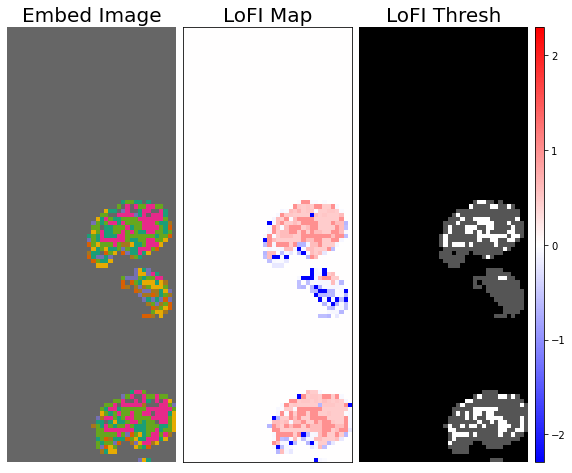

In [149]:
Z_path = "/home/data/tinycam/train/Zs/Z-tumor_045.npy"
M = lofi_map(Z_path, kmeans_model, FI=importance_cben, mode="clusterbag")
visualize_ZM(Z_path, M, kmeans_model, crop_dict)

thresholding at 4.790507898844055


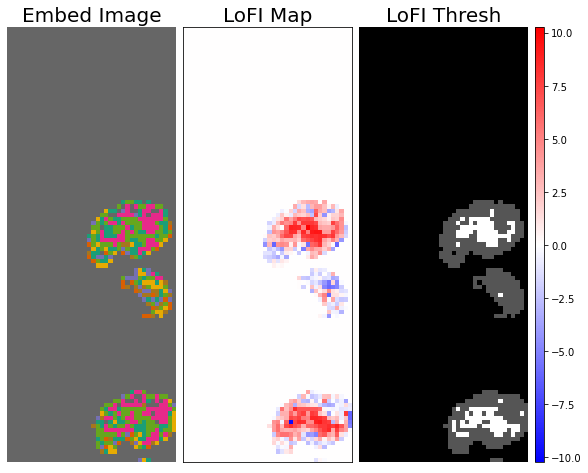

In [150]:
Z_path = "/home/data/tinycam/train/Zs/Z-tumor_045.npy" #045
M = lofi_map(Z_path, kmeans_model, FI=importance_ccben, mode="coclusterbag")
visualize_ZM(Z_path, M, kmeans_model, crop_dict)

thresholding at 0.07831749188758715


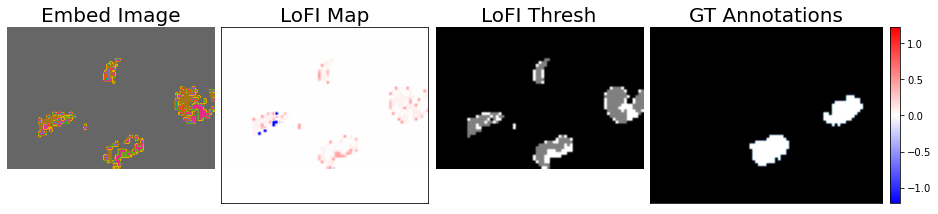

In [139]:
Z_path = "/home/data/tinycam/val/Zs/Z-patient_051_node_2.npy" 
mask_path = "/home/data/tinycam/val/salient_masks/patient_051_node_2_MASK.npy" 
crop_dict = deserialize("/home/codex_analysis/codex-analysis/code/val_crop_coords.obj")
M = lofi_map(Z_path, kmeans_model, FI=importance_ccben, mode="clusterbag")
visualize_ZM(Z_path, M, kmeans_model, crop_dict, mask_path)

## ConvMixer on Zs

In [ ]:
from models import ConvMixer
import torch.optim as optim

In [ ]:
# ic=1
# m="clusterZ"

# ic=128
# m="fullZ"
# dim, depth = 512, 20 #hidden dim, depthwise conv 
# adapter = ConvMixer(dim, depth, in_channels=ic, kernel_size=9, patch_size=7, n_classes=2)
# optimizer = optim.Adam(adapter.parameters(), lr=1e-6)
# model, train_losses, val_losses = train_on_Z(adapter, device, optimizer, Zs_path, label_dict_path, train_set, val_set, epochs=20, mode=m, kmeans_model=kmeans_model)

--------------------------------------------------

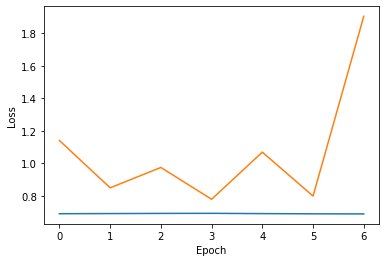

In [42]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Older Visualizations for single images

In [18]:
scope = ["normal_045"] #["normal_045", "normal_068", "tumor_033", "tumor_077"]
model_path = "/home/codex_analysis/codex-analysis/models/cam/ResNet18-hdf5_triplets_random_loading-224-label_selfsup-custom_loss-on_cam-cam16-filtration_background_epoch1.pt"
embed_dict = inference_z(model_path, patch_dir, scope=scope)

GPU detected? False

Note: gpu NOT available!
We have 192618 unique patches to embed
loading model for inference...
Specifically embedding for data: ['normal_045']


In [19]:
import utils
utils.serialize(embed_dict, "inference_z_embeds.obj")

total embeds: (1137, 128)
(1137, 2)
Z is of size: [102, 47]


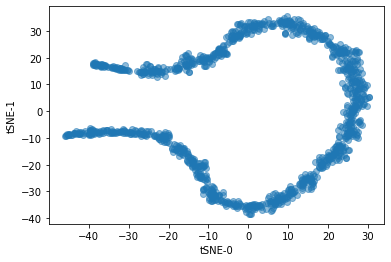

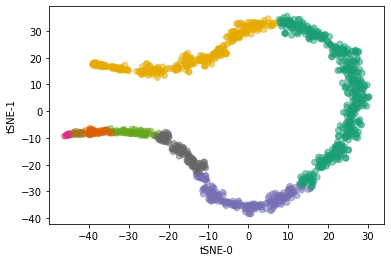

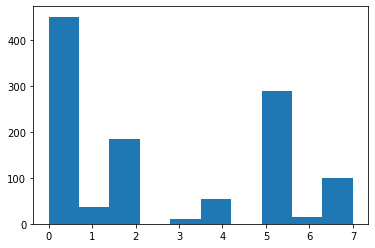

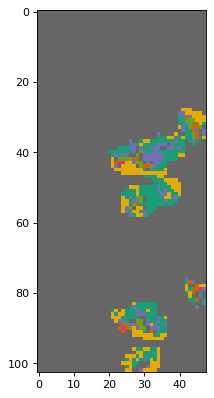

[[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]


In [47]:
embed_dict_path = "inference_z_embeds.obj"
visualize_z(embed_dict_path, dim_dict, scope=scope)